# Mushroom Network

### Librairies :

In [ ]:
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers, regularizers, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten, Dropout
import pandas as pd
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

%matplotlib inline

## Récupération et prétraitement des données

### Chargement des données

Téléchargement depuis git :

In [ ]:
!git clone https://github.com/ddahon/mushroom-neural-network.git
path = "./mushroom-neural-network/data/"

fatal: destination path 'mushroom-neural-network' already exists and is not an empty directory.


Création de listes contenant les noms des images des ensemble d'apprentissage, de validation et de test, ainsi que les labels associés (
  0:agaricus-bisporus,
  1:amanita-muscaria,
  2:boletus-edulis,
  3:cantharellus-cibarius,
  4:entomola-sinatum,
  5:lactarius-deliciosus,
  6:lycoperdon-perlatum,
  7:macrolepiota-procera,
  8:morchella-esculenta,
  9:rubroboletus-satanas
)

In [ ]:
import os
import shutil

mushrooms_names= ["agaricus-bisporus",
                  "amanita-muscaria",
                  "boletus-edulis",
                  "cantharellus-cibarius",
                  "entoloma-sinuatum",
                  "lactarius-deliciosus",
                  "lycoperdon-perlatum",
                  "macrolepiota-procera",
                  "morchella-esculenta",
                  "rubroboletus-satanas"]
image_size = 150

#Images d'entrainement
train_filenames= []
for name in mushrooms_names:
  train_filenames.append(os.listdir(path + "train/" + name))

if not os.path.exists(path + "train/train"):
  os.mkdir(path + "train/train")

path_train = path + "train/"
for i in range(10):
  for filename in train_filenames[i]:
    img = Image.open(path_train+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_train+"train/"+filename)

train_filenames = os.listdir(path + "train/train")
train_categories=[]
for filename in train_filenames:
    category = filename.split('_')[0]
    train_categories.append(mushrooms_names.index(category))

#Images de validation
validation_filenames= []
for name in mushrooms_names:
  validation_filenames.append(os.listdir(path + "validation/" + name))

if not os.path.exists(path + "validation/validation"):
  os.mkdir(path + "validation/validation")

path_validation = path + "validation/"
for i in range(10):
  for filename in validation_filenames[i]:
    img = Image.open(path_validation+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_validation+"validation/"+filename)

validation_filenames = os.listdir(path + "validation/validation")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('_')[0]
    validation_categories.append(mushrooms_names.index(category))

#Images de test
test_filenames= []
for name in mushrooms_names:
  test_filenames.append(os.listdir(path + "test/" + name))

if not os.path.exists(path + "test/test"):
  os.mkdir(path + "test/test")

path_test = path + "test/"
for i in range(10):
  for filename in test_filenames[i]:
    img = Image.open(path_test+mushrooms_names[i]+"/"+filename).convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(path_test+"test/"+filename)

test_filenames = os.listdir(path + "test/test")
test_categories=[]
for filename in test_filenames:
    category = filename.split('_')[0]
    test_categories.append(mushrooms_names.index(category))

Création de DataFrames

In [ ]:
#Images d'entrainement
train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})


#Images de validation
validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


#Images de test
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


train_df['category'] = train_df['category'].astype(str)
validation_df['category'] = validation_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

### Prétraitement des images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16


#Images d'entrainement
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path + "train/train/",
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=batch_size
)

#Images de validation
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    path + "validation/validation", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

#Images de test
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    path + "test/test", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    shuffle = False,
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
[2, 3, 2, 2, 8, 3, 5, 6, 3, 0, 0, 2, 4, 3, 7, 0, 8, 1, 5, 5, 5, 8, 3, 6, 4, 1, 6, 1, 8, 1, 1, 9, 0, 7, 2, 2, 4, 6, 6, 2, 9, 3, 2, 5, 2, 4, 3, 4, 4, 8, 5, 8, 6, 8, 0, 4, 6, 3, 1, 4, 0, 8, 0, 7, 0, 4, 6, 1, 5, 7, 3, 5, 3, 9, 6, 2, 7, 4, 2, 8, 3, 2, 7, 1, 3, 1, 4, 8, 5, 0, 2, 6, 5, 7, 0, 7, 5, 4, 9, 6, 7, 1, 4, 4, 4, 4, 9, 1, 8, 9, 3, 9, 1, 2, 8, 6, 9, 3, 1, 0, 5, 8, 3, 6, 2, 3, 7, 0, 2, 1, 8, 4, 7, 8, 3, 5, 7, 4, 7, 4, 7, 1, 8, 9, 4, 0, 9, 5, 8, 3, 9, 7, 4, 6, 2, 6, 5, 9, 0, 0, 7, 2, 8, 1, 2, 0, 8, 9, 5, 4, 0, 2, 6, 8, 7, 4, 8, 7, 2, 8, 7, 1, 9, 6, 9, 0, 5, 9, 5, 1, 1, 0, 6, 9, 0, 6, 5, 5, 3, 1, 9, 0, 9, 5, 5, 7, 2, 9, 9, 6, 2, 9, 3, 2, 1, 3, 6, 9, 1, 1, 4, 7, 9, 2, 7, 8, 0, 6, 3, 6, 5, 6, 8, 5, 7, 0, 6, 3, 5, 9, 7, 8, 0, 1, 1, 4, 0, 3, 3, 7]


## Modèle convolutif de base

In [ ]:
model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=96, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(10, activation='softmax'))   # Couche de sortie

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

### Entrainement

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
32/32 [==============================] - 2s 36ms/step - loss: 2.3145 - acc: 0.1003 - val_loss: 2.2554 - val_acc: 0.1560
Epoch 2/20
32/32 [==============================] - 1s 28ms/step - loss: 2.1504 - acc: 0.2171 - val_loss: 1.8189 - val_acc: 0.3120
Epoch 3/20
32/32 [==============================] - 1s 29ms/step - loss: 1.6932 - acc: 0.3530 - val_loss: 1.6036 - val_acc: 0.4480
Epoch 4/20
32/32 [==============================] - 1s 28ms/step - loss: 1.3387 - acc: 0.6116 - val_loss: 1.4281 - val_acc: 0.5040
Epoch 5/20
32/32 [==============================] - 1s 29ms/step - loss: 1.1204 - acc: 0.6252 - val_loss: 1.4375 - val_acc: 0.5000
Epoch 6/20
32/32 [==============================] - 1s 29ms/step - loss: 1.0212 - acc: 0.6631 - val_loss: 1.3276 - val_acc: 0.5400
Epoch 7/20
32/32 [==============================] - 1s 28ms/step - loss: 0.7818 - acc: 0.7385 - val_loss: 1.4809 - val_acc: 0.6080
Epoch 8/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6426 - a

### Analyse des résultats du modèle

In [ ]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

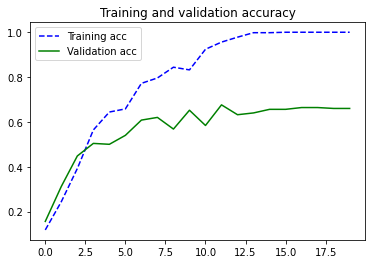

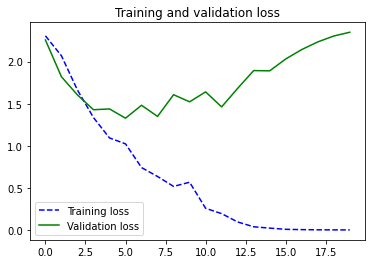

In [ ]:
plot_training_analysis()

loss: 234.54%
acc: 58.80%
Confusion matrix
[[13  0  2  0  4  1  2  2  0  1]
 [ 0 15  0  1  0  4  0  1  3  1]
 [ 1  0 13  0  5  2  1  2  1  0]
 [ 0  0  2 16  0  4  0  1  0  2]
 [ 5  0  1  2 12  1  1  2  0  1]
 [ 2  0  5  1  1 10  1  3  0  2]
 [ 3  0  1  0  5  0 14  2  0  0]
 [ 4  1  0  0  0  0  3 15  0  2]
 [ 2  0  1  1  0  0  0  3 18  0]
 [ 1  0  1  1  0  1  0  0  0 21]]
Pourcentage de precision de chaque classe:
[41.935483870967744, 93.75, 50.0, 72.72727272727273, 44.44444444444444, 43.47826086956522, 63.63636363636363, 48.38709677419355, 81.81818181818181, 70.0]


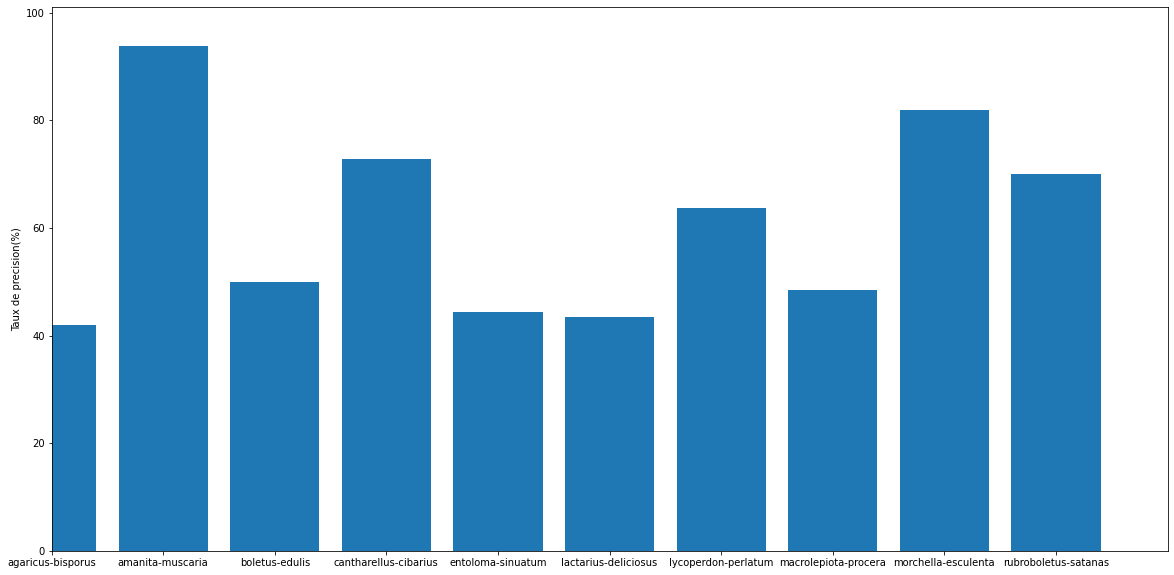

In [ ]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Confusion matrix")
cm = confusion_matrix(test_generator.classes, predicted_class_indices)
print(cm)
precision=[]
for i in range(10):
  precision.append(100 * cm[i][i]/sum(cm[:,i]))

fig = plt.figure(1, figsize=(20, 10))
plt.bar(mushrooms_names, precision)
plt.axis([0, 10, 0, 101])
plt.ylabel('Taux de precision(%)')
print("Pourcentage de precision de chaque classe:")
print(precision)


Malgré la simplicité du réseau les données d'apprentissage sont parfaitement apprises, ce qui est déjà un bon signe ; cependant le sur-apprentissage est comme on pouvait s'y attendre conséquent : une première amélioration est d'augmenter la base de données et appliquer des techniques de régularisation de base.

## Augmentation de la base de données

In [ ]:
train_datagen_2 = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator_augmented = train_datagen_2.flow_from_dataframe(
    train_df, 
    path + 'train/train/',
    x_col='filename',
    y_col='category',
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 10 classes.


### Apprentissage

In [ ]:
model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=96, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(10, activation='softmax'))   # Couche de sortie

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=40,
                    )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

loss: 104.82%
acc: 70.80%
Confusion matrix
[[12  0  2  0  8  2  1  0  0  0]
 [ 0 20  3  1  0  0  0  0  0  1]
 [ 0  4 16  0  1  0  3  1  0  0]
 [ 0  0  0 18  0  6  0  1  0  0]
 [ 0  0  1  2 16  0  3  1  2  0]
 [ 1  2  5  1  2 14  0  0  0  0]
 [ 3  0  0  0  1  0 20  1  0  0]
 [ 1  0  3  0  0  1  1 17  2  0]
 [ 0  0  3  1  0  1  0  0 20  0]
 [ 0  1  0  0  0  0  0  0  0 24]]
Pourcentage de precision de chaque classe:
[70.58823529411765, 74.07407407407408, 48.484848484848484, 78.26086956521739, 57.142857142857146, 58.333333333333336, 71.42857142857143, 80.95238095238095, 83.33333333333333, 96.0]


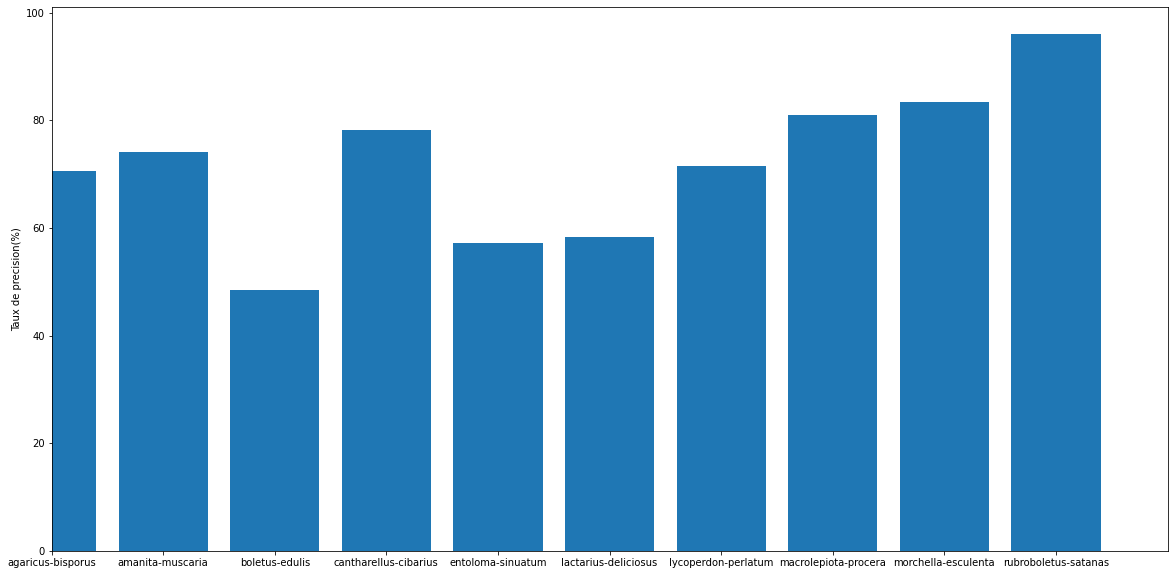

In [ ]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Confusion matrix")
cm = confusion_matrix(test_generator.classes, predicted_class_indices)
print(cm)
precision=[]
for i in range(10):
  precision.append(100 * cm[i][i]/sum(cm[:,i]))

fig = plt.figure(1, figsize=(20, 10))
plt.bar(mushrooms_names, precision)
plt.axis([0, 10, 0, 101])
plt.ylabel('Taux de precision(%)')
print("Pourcentage de precision de chaque classe:")
print(precision)


### Analyse des résultats

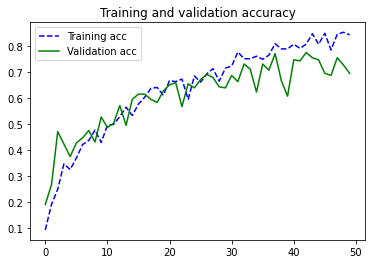

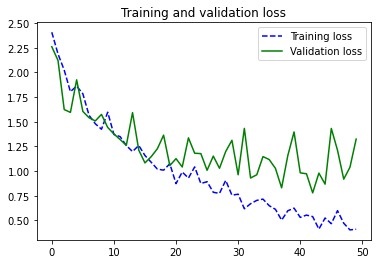

In [ ]:
plot_training_analysis()

Pour ce qui est des données de validation les résultats restent inchangés, cependant la manière avec laquelle le sur-apprentissage est diminué peuvent indiquer qu'en poussant l'apprentissage plus longtemps et avec un modèle plus abouti on peut obtenir des résultats habituels.

## Test - Réseau plus complexe

In [ ]:
model = models.Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(512, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(512, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(10, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=50,
                    )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 148, 148, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 37, 37, 256)     

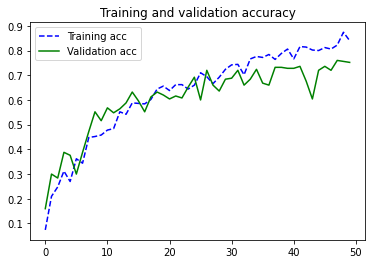

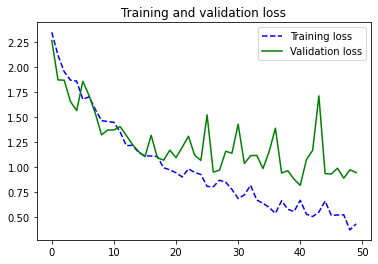

In [ ]:
plot_training_analysis()

loss: 111.89%
acc: 70.80%
Confusion matrix
[[ 8  0  2  0  8  2  0  4  1  0]
 [ 0 18  2  1  0  3  0  0  1  0]
 [ 1  1 16  1  3  0  0  1  0  2]
 [ 0  0  0 20  0  5  0  0  0  0]
 [ 3  0  1  1 17  0  0  1  2  0]
 [ 0  0  2  1  3 17  0  2  0  0]
 [ 0  0  0  0  8  1 14  2  0  0]
 [ 0  0  1  0  1  1  0 22  0  0]
 [ 0  0  0  0  0  2  0  0 23  0]
 [ 0  0  0  0  0  2  0  1  0 22]]
Pourcentage de precision de chaque classe:
[66.66666666666667, 94.73684210526316, 66.66666666666667, 83.33333333333333, 42.5, 51.515151515151516, 100.0, 66.66666666666667, 85.18518518518519, 91.66666666666667]


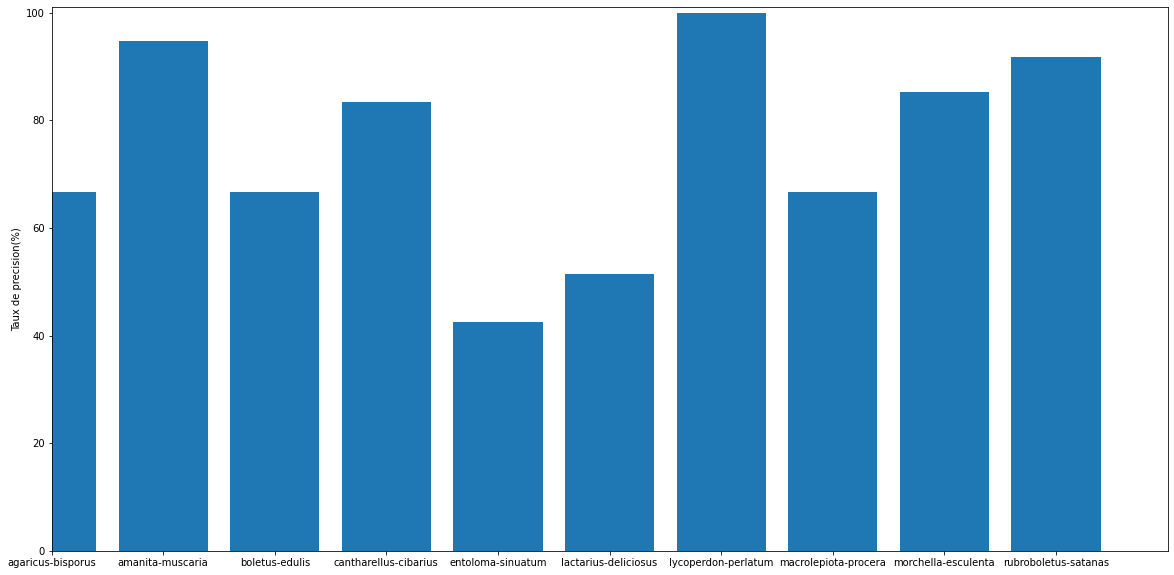

In [ ]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Confusion matrix")
cm = confusion_matrix(test_generator.classes, predicted_class_indices)
print(cm)
precision=[]
for i in range(10):
  precision.append(100 * cm[i][i]/sum(cm[:,i]))

fig = plt.figure(1, figsize=(20, 10))
plt.bar(mushrooms_names, precision)
plt.axis([0, 10, 0, 101])
plt.ylabel('Taux de precision(%)')
print("Pourcentage de precision de chaque classe:")
print(precision)

## Test - Transfer Learning

In [ ]:
from keras.applications import VGG16

lamb = 0.08

model = models.Sequential()

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(150, 150, 3))

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
# model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(lamb)))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(lamb)))

conv_base.trainable = False
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history1 = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=15,
                    )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_21 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 5s 128ms/step - loss: 36.9381 - acc: 0.2432 - val_loss: 20.4722 - val_acc: 0.5640
Epoch 2/15
32/32 [==============================] - 4s 119ms/step - loss: 17.5226 - acc: 0.4729 - 

In [ ]:
conv_base.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit(train_generator_augmented, 
                    validation_data=validation_generator,
                    epochs=15,
                    )

Epoch 1/15
32/32 [==============================] - 6s 156ms/step - loss: 1.9306 - acc: 0.7547 - val_loss: 1.7150 - val_acc: 0.8200
Epoch 2/15
32/32 [==============================] - 5s 152ms/step - loss: 1.6384 - acc: 0.8492 - val_loss: 1.6760 - val_acc: 0.8240
Epoch 3/15
32/32 [==============================] - 5s 151ms/step - loss: 1.5176 - acc: 0.8846 - val_loss: 1.5376 - val_acc: 0.8680
Epoch 4/15
32/32 [==============================] - 5s 151ms/step - loss: 1.4596 - acc: 0.8922 - val_loss: 1.5427 - val_acc: 0.8560
Epoch 5/15
32/32 [==============================] - 5s 152ms/step - loss: 1.3831 - acc: 0.9289 - val_loss: 1.5330 - val_acc: 0.8760
Epoch 6/15
32/32 [==============================] - 5s 152ms/step - loss: 1.3792 - acc: 0.9245 - val_loss: 1.4922 - val_acc: 0.8840
Epoch 7/15
32/32 [==============================] - 5s 153ms/step - loss: 1.2519 - acc: 0.9569 - val_loss: 1.4898 - val_acc: 0.8720
Epoch 8/15
32/32 [==============================] - 5s 153ms/step - loss: 1.

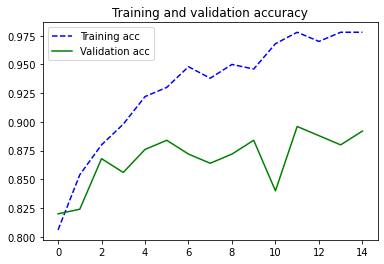

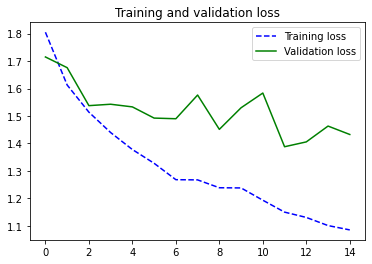

In [ ]:
plot_training_analysis()

## Analyse des resultats du reseau final

loss: 155.95%
acc: 85.60%
Confusion matrix
[[18  0  1  2  1  1  0  1  0  1]
 [ 0 24  0  0  0  1  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0]
 [ 0  0  0 21  0  4  0  0  0  0]
 [ 2  0  0  1 17  2  0  2  0  1]
 [ 2  0  1  0  1 19  0  2  0  0]
 [ 4  0  0  0  1  0 19  1  0  0]
 [ 0  1  1  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0  0 25  0]
 [ 0  0  1  0  0  0  0  0  0 24]]
Pourcentage de precision de chaque classe:
[69.23076923076923, 96.0, 85.71428571428571, 87.5, 85.0, 67.85714285714286, 100.0, 79.3103448275862, 100.0, 92.3076923076923]


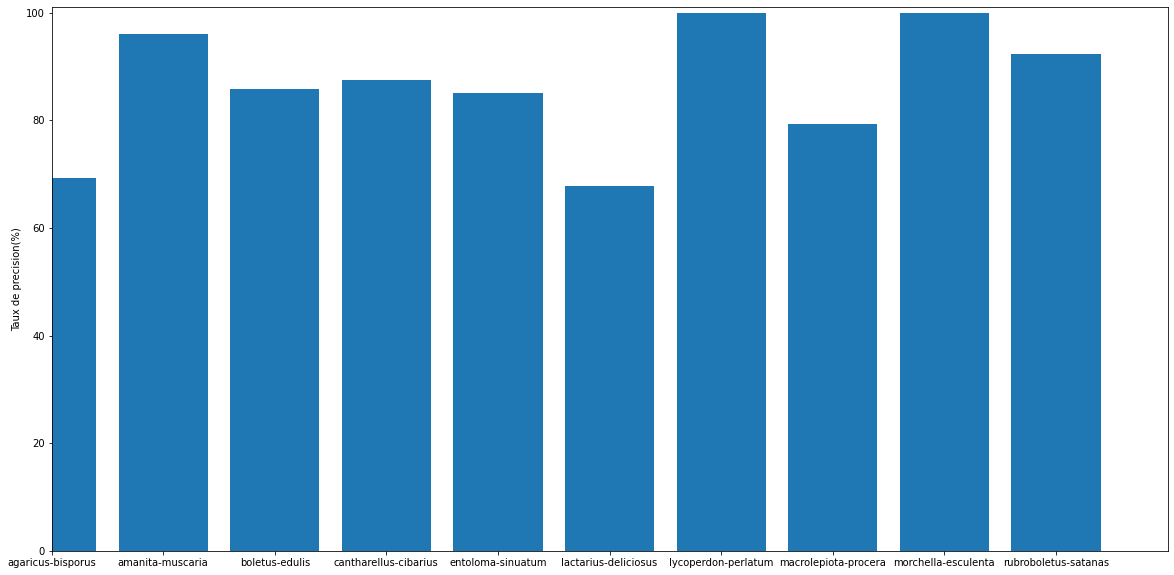

In [ ]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Confusion matrix")
cm = confusion_matrix(test_generator.classes, predicted_class_indices)
print(cm)
precision=[]
for i in range(10):
  precision.append(100 * cm[i][i]/sum(cm[:,i]))

fig = plt.figure(1, figsize=(20, 10))
plt.bar(mushrooms_names, precision)
plt.axis([0, 10, 0, 101])
plt.ylabel('Taux de precision(%)')
print("Pourcentage de precision de chaque classe:")
print(precision)


##Analyse quantitative

In [ ]:
def print_prediction(x,y,y_pred):
  
  # Détermination de la classe
  class_id = np.argmax(y)
  class_id_pred = np.argmax(y_pred)

  # Affichage de l'image
  plt.imshow(x)
  plt.title("Prédiction : {}, Vérité terrain : {}".format(mushrooms_names[class_id_pred], mushrooms_names[class_id]))
  plt.show()

In [ ]:
(x_val,y_val) = next(validation_generator)
y_pred = model.predict(x_val)

for i in range(10):
  print_prediction(x_val[i], y_val[i], y_pred[i])